In [1]:
import torch
import torchvision
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# import the dataset and loader from data_utils.py
import data_utils
image_folder_path = 'dataset/image_postprocess'
desired_image_size = (64, 64)

# set batch size to 100 
batch_size = 100
# create a dataset so that dataset[i] returns the ith image
dataset = data_utils.Dataset(image_folder_path, desired_image_size)
# make a dataloader that returns the images as batches for parallel processing
dataloader = torch.utils.data.DataLoader(dataset, batch_size)

In [3]:
# import the models from model.py
import models
generator = models.Generator()
discriminator = models.Discriminator()

In [7]:
# use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

In [8]:
# Initialize the loss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# set a learning rate (typically around 1e-3)
lr = 0.0001

# Setup optimizers for both generator and discriminator
optimizerD = torch.optim.AdamW(discriminator.parameters(), lr=lr)
optimizerG = torch.optim.AdamW(generator.parameters(), lr=lr)

In [9]:
# functions that save and load the model and optimizer
save_to = './checkpoints/model.pt'
def save(path, generator, discriminator, optimizerG, optimizerD):
    torch.save(
        {
            'generator_weights' : generator.state_dict(),
            'discriminator_weights' : discriminator.state_dict(),
            'generator_optimizer_weights' : optimizerG.state_dict(),
            'discriminator_optimizer_weights' : optimizerD.state_dict(),
        },
        path
    )

def load(path):
    # initialize 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(path)
    generator = models.Generator().to(device)
    discriminator = models.Discriminator().to(device)

    optimizerG = torch.optim.Adam(generator.parameters(), lr=lr)
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr)

    generator.load_state_dict(checkpoint['generator_weights'])
    discriminator.load_state_dict(checkpoint['discriminator_weights'])
    optimizerG.load_state_dict(checkpoint['generator_optimizer_weights'])
    optimizerD.load_state_dict(checkpoint['discriminator_optimizer_weights'])

    return generator, discriminator, optimizerG, optimizerD

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/maxin/opt/anaconda3/envs/cassava/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[1/500][0/19]	Loss_D: 1.3884	Loss_G: 0.6280	D(x): 0.5350	D(G(z)): 0.5337 / 0.5336
[1/500][1/19]	Loss_D: 1.3873	Loss_G: 0.6281	D(x): 0.5355	D(G(z)): 0.5336 / 0.5336
[1/500][2/19]	Loss_D: 1.3861	Loss_G: 0.6281	D(x): 0.5362	D(G(z)): 0.5336 / 0.5336
[1/500][3/19]	Loss_D: 1.3848	Loss_G: 0.6280	D(x): 0.5368	D(G(z)): 0.5336 / 0.5337
[1/500][4/19]	Loss_D: 1.3836	Loss_G: 0.6279	D(x): 0.5375	D(G(z)): 0.5337 / 0.5337
[1/500][5/19]	Loss_D: 1.3824	Loss_G: 0.6276	D(x): 0.5383	D(G(z)): 0.5337 / 0.5339
[1/500][6/19]	Loss_D: 1.3812	Loss_G: 0.6273	D(x): 0.5391	D(G(z)): 0.5339 / 0.5341
[1/500][7/19]	Loss_D: 1.3799	Loss_G: 0.6269	D(x): 0.5400	D(G(z)): 0.5340 / 0.5342
[1/500][8/19]	Loss_D: 1.3781	Loss_G: 0.6266	D(x): 0.5412	D(G(z)): 0.5342 / 0.5344
[1/500][9/19]	Loss_D: 1.3771	Loss_G: 0.6265	D(x): 0.5419	D(G(z)): 0.5344 / 0.5345
[1/500][10/19]	Loss_D: 1.3757	Loss_G: 0.6267	D(x): 0.5427	D(G(z)): 0.5344 / 0.5344
[1/500][11/19]	Loss_D: 1.3737	Loss_G: 0.6270	D(x): 0.5437	D(G(z)): 0.5344 / 0.5342
[1/500][12/19]

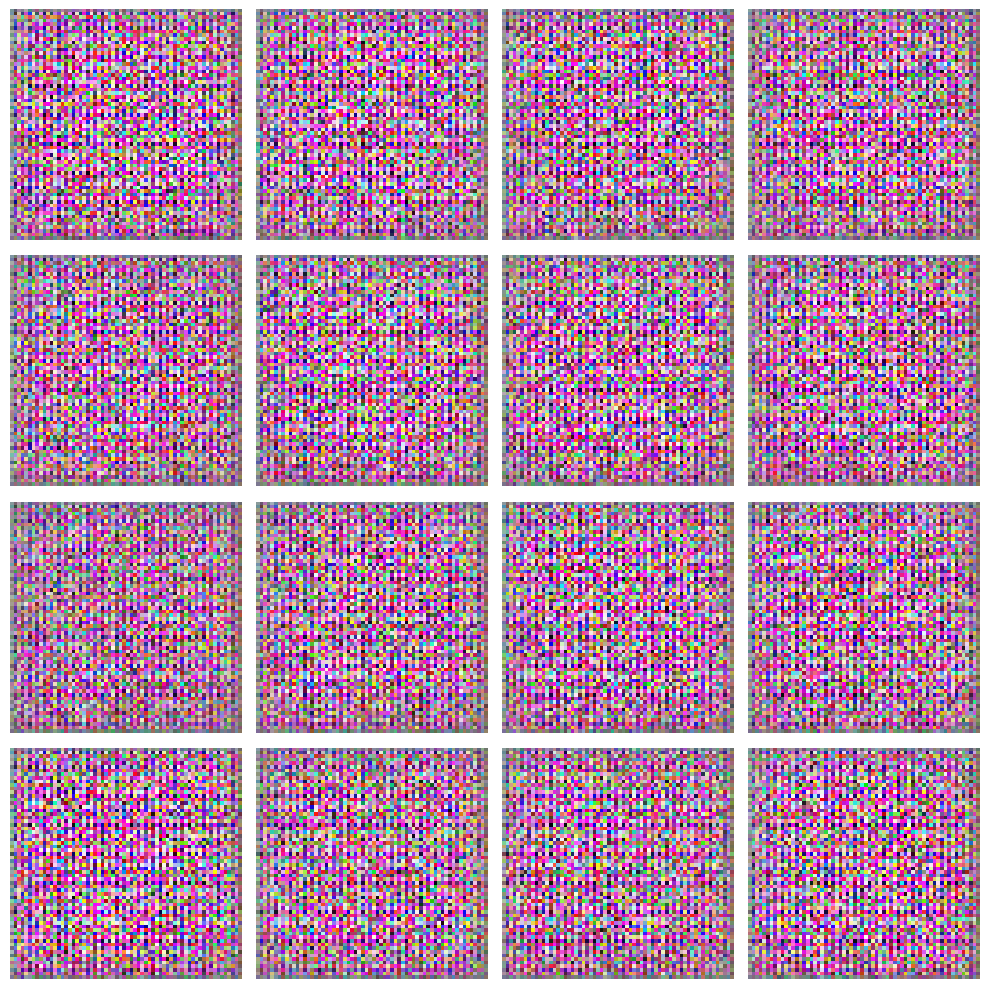

Generated images at epoch 5, batch 15
[5/500][1/19]	Loss_D: 0.6968	Loss_G: 0.6883	D(x): 0.9999	D(G(z)): 0.5018 / 0.5025
[5/500][2/19]	Loss_D: 0.6979	Loss_G: 0.6874	D(x): 1.0000	D(G(z)): 0.5023 / 0.5029
[5/500][3/19]	Loss_D: 0.6988	Loss_G: 0.6884	D(x): 1.0000	D(G(z)): 0.5028 / 0.5024
[5/500][4/19]	Loss_D: 0.6980	Loss_G: 0.6899	D(x): 0.9999	D(G(z)): 0.5024 / 0.5016
[5/500][5/19]	Loss_D: 0.6971	Loss_G: 0.6925	D(x): 0.9999	D(G(z)): 0.5019 / 0.5004
[5/500][6/19]	Loss_D: 0.6937	Loss_G: 0.6944	D(x): 0.9998	D(G(z)): 0.5002 / 0.4994
[5/500][7/19]	Loss_D: 0.6927	Loss_G: 0.6950	D(x): 0.9990	D(G(z)): 0.4992 / 0.4991
[5/500][8/19]	Loss_D: 0.6923	Loss_G: 0.6939	D(x): 0.9996	D(G(z)): 0.4994 / 0.4996
[5/500][9/19]	Loss_D: 0.6923	Loss_G: 0.6914	D(x): 0.9999	D(G(z)): 0.4995 / 0.5009
[5/500][10/19]	Loss_D: 0.6955	Loss_G: 0.6890	D(x): 0.9999	D(G(z)): 0.5011 / 0.5021
[5/500][11/19]	Loss_D: 0.6975	Loss_G: 0.6877	D(x): 1.0000	D(G(z)): 0.5022 / 0.5027
[5/500][12/19]	Loss_D: 0.6980	Loss_G: 0.6884	D(x): 1.0000	

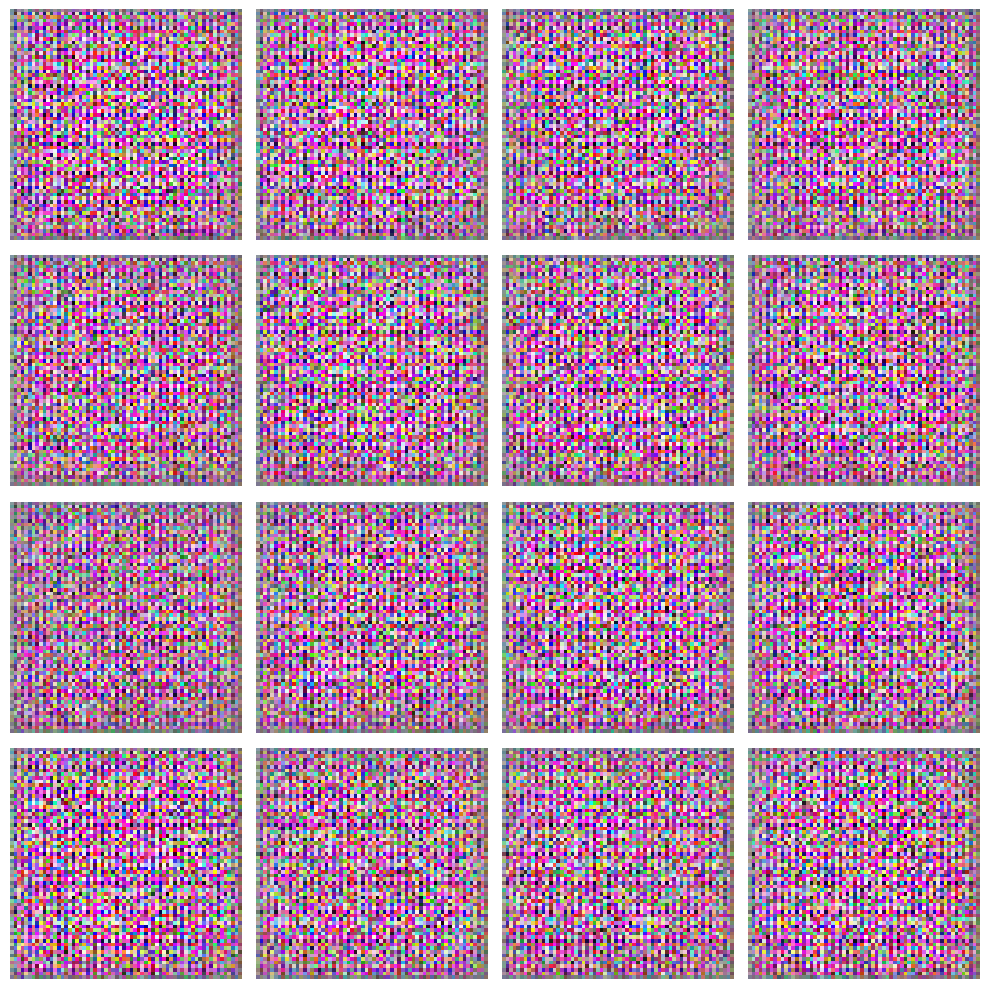

Generated images at epoch 10, batch 15
[10/500][1/19]	Loss_D: 0.6942	Loss_G: 0.6924	D(x): 1.0000	D(G(z)): 0.5005 / 0.5004
[10/500][2/19]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5002 / 0.5000
[10/500][3/19]	Loss_D: 0.6935	Loss_G: 0.6933	D(x): 1.0000	D(G(z)): 0.5001 / 0.4999
[10/500][4/19]	Loss_D: 0.6932	Loss_G: 0.6936	D(x): 0.9999	D(G(z)): 0.5000 / 0.4998
[10/500][5/19]	Loss_D: 0.6931	Loss_G: 0.6935	D(x): 0.9999	D(G(z)): 0.4999 / 0.4998
[10/500][6/19]	Loss_D: 0.6926	Loss_G: 0.6939	D(x): 0.9999	D(G(z)): 0.4997 / 0.4996
[10/500][7/19]	Loss_D: 0.6934	Loss_G: 0.6936	D(x): 0.9991	D(G(z)): 0.4996 / 0.4998
[10/500][8/19]	Loss_D: 0.6927	Loss_G: 0.6935	D(x): 0.9997	D(G(z)): 0.4996 / 0.4998
[10/500][9/19]	Loss_D: 0.6933	Loss_G: 0.6929	D(x): 0.9999	D(G(z)): 0.5001 / 0.5001
[10/500][10/19]	Loss_D: 0.6930	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.4999 / 0.5000
[10/500][11/19]	Loss_D: 0.6932	Loss_G: 0.6925	D(x): 1.0000	D(G(z)): 0.5000 / 0.5003
[10/500][12/19]	Loss_D: 0.6943	Loss_G: 0.6920	

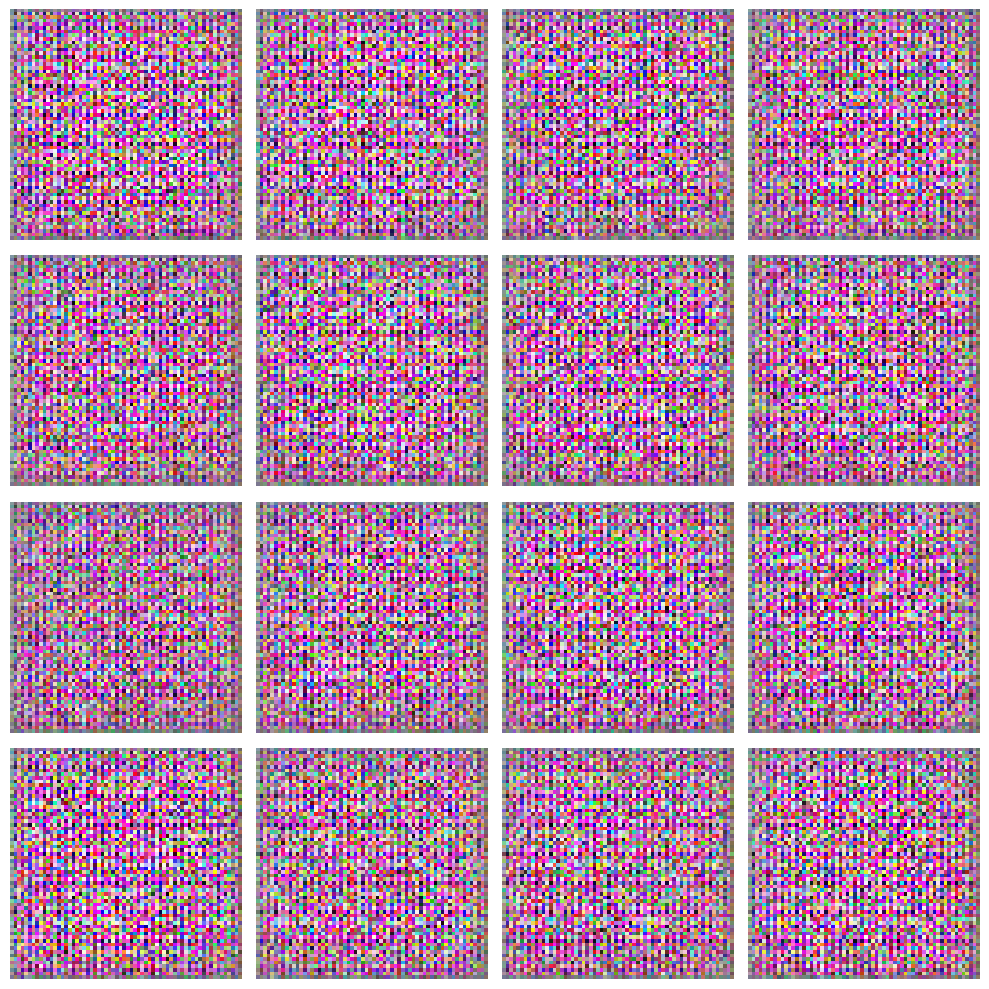

Generated images at epoch 15, batch 15
[15/500][1/19]	Loss_D: 0.6933	Loss_G: 0.6927	D(x): 1.0000	D(G(z)): 0.5001 / 0.5002
[15/500][2/19]	Loss_D: 0.6941	Loss_G: 0.6927	D(x): 1.0000	D(G(z)): 0.5005 / 0.5002
[15/500][3/19]	Loss_D: 0.6937	Loss_G: 0.6930	D(x): 1.0000	D(G(z)): 0.5002 / 0.5001
[15/500][4/19]	Loss_D: 0.6933	Loss_G: 0.6934	D(x): 1.0000	D(G(z)): 0.5000 / 0.4999
[15/500][5/19]	Loss_D: 0.6927	Loss_G: 0.6935	D(x): 0.9999	D(G(z)): 0.4997 / 0.4998
[15/500][6/19]	Loss_D: 0.6932	Loss_G: 0.6933	D(x): 0.9999	D(G(z)): 0.5000 / 0.4999
[15/500][7/19]	Loss_D: 0.6935	Loss_G: 0.6933	D(x): 0.9992	D(G(z)): 0.4998 / 0.4999
[15/500][8/19]	Loss_D: 0.6933	Loss_G: 0.6934	D(x): 0.9998	D(G(z)): 0.5000 / 0.4999
[15/500][9/19]	Loss_D: 0.6930	Loss_G: 0.6933	D(x): 1.0000	D(G(z)): 0.4999 / 0.4999
[15/500][10/19]	Loss_D: 0.6929	Loss_G: 0.6933	D(x): 0.9999	D(G(z)): 0.4999 / 0.4999
[15/500][11/19]	Loss_D: 0.6933	Loss_G: 0.6928	D(x): 1.0000	D(G(z)): 0.5001 / 0.5002
[15/500][12/19]	Loss_D: 0.6932	Loss_G: 0.6926	

In [11]:
# create a loop to train the model

num_epochs = 500

optimizerD.zero_grad()
optimizerG.zero_grad()

for epoch in tqdm(range(1, 1+num_epochs)):
    for i, data in enumerate(dataloader, 0):

        ########################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #######################################################
        
        ## Train the Discriminator on Real Data
        discriminator.train() 
        label = torch.full((len(data),), real_label) # Create a tensor filled with 'real_label' values, representing labels the discriminator should predict for real images.
        output = discriminator(data) # Pass real images through the discriminator and flatten the output.
        # no need for an argmax, model has a sigmoid on the latest layer, will output probablility of real
        
        label = label.double() # Format the labels
        output = torch.squeeze(output.double(), dim=1) # Format the outputs
        
        errD_real = criterion(output, label)       # Calculate loss between discriminator's predictions and real labels.
        errD_real.backward()                       # Compute the gradients based on the loss

        D_x = output.mean().item()

        ## Train the Discriminator on Fake Data
        noise = torch.randn(len(data), 100, 1, 1)  # Generate random noise to feed into the generator.
        
        optimizerG.zero_grad()
        # bug fix: torch.no_grad() means pytorch will not produce gradients for this 
        # only want to produce gradients once before backprop
        with torch.no_grad():    
            fake = generator(noise)                           # Use the generator to produce fake images from the noise.
        label = torch.full((len(fake), ), fake_label)     # Change the label values to 'fake_label', representing fake images.

        # Pass the fake images (detached to avoid gradient computation for the generator) through the discriminator and flatten the output.
        output = discriminator(fake)
        
        label = label.double()
        output = torch.squeeze(output.double(), dim=1)

        errD_fake = criterion(output, label)              # Calculate loss between discriminator's predictions and fake labels.
        errD_fake.backward()                             # Compute the gradients based on the loss.

        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake  # Total discriminator loss is the sum of losses on real and fake data.
        optimizerD.step()  
        optimizerD.zero_grad()

        ########################################################
        # (2) Update G network: maximize log(D(G(z)))
        #######################################################
        
        ## Train the Generator
        generator.train()
        label.fill_(real_label)      # For the generator's loss, the goal is to have the discriminator label its output as real, hence using 'real_label'.
        output = discriminator(fake)  # Pass the previously generated fake images through the discriminator.

        
        label = label.double()
        output = torch.squeeze(output.double(), dim=1)

        # Calculate loss for the generator based on how well the discriminator was fooled.
        errG = criterion(output, label)
        errG.backward()  # Compute the gradients based on the generator's loss.
        optimizerG.step() # Update the generator's parameters based on computed gradients.
        optimizerG.zero_grad()

        D_G_z2 = output.mean().item()

        # Output training stats after every batch for demonstration.
        # print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()}")

        # Output training stats
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        # G_losses.append(errG.item())
        # D_losses.append(errD.item())

        # Periodically check the generator's outputs (here, every 50 batches as an example).
        if epoch % 5 == 0 and i % 19 == 0:
            with torch.no_grad():
                generator.eval()
                discriminator.eval() 

                fake = generator(fixed_noise).detach().cpu()

                # Normalize the generated images 
                fake = (fake + 1) / 2.0

                # Plot some of the generated images
                plt.figure(figsize=(10,10))

                for i in range(16): # Displaying the first 16 images as an example
                    plt.subplot(4, 4, i+1)
                    plt.imshow(fake[i].permute(1, 2, 0).squeeze(), cmap='gray')
                    plt.axis('off')

                plt.tight_layout()
                plt.show()

            print(f"Generated images at epoch {epoch}, batch {i}")

In [2]:
# generate images from the model

# set the generator to evaluation mode (this can affect behavior for layers like BatchNorm)
generator.eval()

# generate a batch of noise vectors
noise = torch.randn(batch_size, 100, 1, 1).to(device)

# generate images from the noise vectors
with torch.no_grad():
    generated_images = generator(noise).cpu()

# convert the images from [-1, 1] range (if they were normalized this way) to [0, 1]
generated_images = (generated_images + 1) / 2.0

# plot some of the generated images
plt.figure(figsize=(10,10))

for i in range(16): # displaying the first 16 images as an example
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'generator' is not defined